In [1]:
import os
import numpy
import xarray
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [2]:
# JP extent
resolution = 0.01 # degree
lats = numpy.arange(50.-resolution/2, 20, -resolution)
lons = numpy.arange(120.+resolution/2, 150, resolution)

In [46]:
def read_mod09ga_site(modis_mod09_tif):
    modis_ds = xarray.open_rasterio(modis_mod09_tif)[0]
    jp_ds = modis_ds.interp(x=lons, y=lats, method="cubic", kwargs={"fill_value": "extrapolate"}) # linear?
    r_dn = numpy.array(jp_ds.values).astype(float)
    
    r_dn[r_dn<0] = numpy.NaN
    data_v = r_dn*0.0001
    
    return data_v
    

def smooth_max_ndvi_95_2d(data_2d, window_size=21, polynomial_order=1, max_percent=0.95):
    
    smoothed_data_2d = []
    for data in data_2d:
    # Interpolate to fill NaN values
        non_nan_indices = numpy.where(~numpy.isnan(data))[0]
        non_nan_values = data[non_nan_indices]
        if len(non_nan_values) > window_size:
            f = interp1d(non_nan_indices, non_nan_values, kind='linear', fill_value='extrapolate')
            interpolated_data = f(numpy.arange(len(data)))

            smoothed_max = None
            for idx in range(31):
                smoothed_max = maximum_filter(interpolated_data, size=idx)

            # Apply Savitzky-Golay filter
            smoothed_data = savgol_filter(smoothed_max*max_percent, window_size, polynomial_order)
            smoothed_data_2d.append(smoothed_data)
        else:
            smoothed_data_2d.append(numpy.full(len(data), numpy.nan))
    return numpy.array(smoothed_data_2d)

In [4]:
REF_FOLDER = '/data01/people/beichen/data_et/MOD09GA_b1b2_JP'

In [53]:
year_str = '2018'
year_str = '2019'
# start_day = 196 # 07/15
# end_day = 227 # 08/15
start_day = 1
end_day = 365

ndvi_o = []
REF_FOLDER_YEAR = os.path.join(REF_FOLDER, year_str)
for doy in range(start_day, end_day+1, 1):
    doy_str = year_str + (3-len(str(doy)))*'0' + str(doy)
    b1_tif_filename = os.path.join(REF_FOLDER_YEAR, 'MOD09GA.061_sur_refl_b01_1_doy'+ doy_str + '_aid0001.tif')
    b2_tif_filename = os.path.join(REF_FOLDER_YEAR, 'MOD09GA.061_sur_refl_b02_1_doy'+ doy_str + '_aid0001.tif')
    ref1_day = read_mod09ga_site(b1_tif_filename)
    ref2_day = read_mod09ga_site(b2_tif_filename)
    ndvi_array = (ref2_day - ref1_day) / (ref2_day + ref1_day)
    ndvi_o.append(ndvi_array)

/tmp/ipykernel_1272040/60047521.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  modis_ds = xarray.open_rasterio(modis_mod09_tif)[0]


In [54]:
ndvi_o = numpy.array(ndvi_o)
o_shape = ndvi_o.shape
ndvi_2d = ndvi_o.reshape((o_shape[0],o_shape[1]*o_shape[2]))
ndvi_2d_T = ndvi_2d.T

In [55]:
smoothed_ndvi_2d_T = smooth_max_ndvi_95_2d(ndvi_2d_T)
smoothed_ndvi_2d = smoothed_ndvi_2d_T.T
smoothed_ndvi_3d = smoothed_ndvi_2d.reshape(o_shape)

## save result

In [56]:
storage_folder = '/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH'
for ndvi_2d_idx in range(len(smoothed_ndvi_3d)):
    save_ndvi_2d = smoothed_ndvi_3d[ndvi_2d_idx]
    storage_filename = os.path.join(storage_folder, year_str, (3-len(str(ndvi_2d_idx+1)))*'0' + str(ndvi_2d_idx+1) +'.npy')
    numpy.save(storage_filename, save_ndvi_2d)
    print(storage_filename)

/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/001.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/002.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/003.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/004.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/005.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/006.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/007.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/008.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/009.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/010.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/011.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/012.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/013.npy
/data01/peop

/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/109.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/110.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/111.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/112.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/113.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/114.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/115.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/116.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/117.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/118.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/119.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/120.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/121.npy
/data01/peop

/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/217.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/218.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/219.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/220.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/221.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/222.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/223.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/224.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/225.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/226.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/227.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/228.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/229.npy
/data01/peop

/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/325.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/326.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/327.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/328.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/329.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/330.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/331.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/332.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/333.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/334.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/335.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/336.npy
/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH/2019/337.npy
/data01/peop

## display

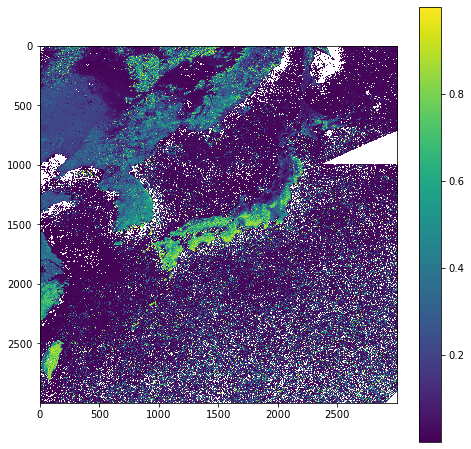

In [48]:
smooth_2d_show = smoothed_ndvi_3d[0]
smooth_2d_show[smooth_2d_show>1] = numpy.NaN
smooth_2d_show[smooth_2d_show<0] = numpy.NaN
plt.figure(figsize=(8,8))
plt.imshow(smoothed_ndvi_3d[0], interpolation='None')
plt.colorbar()

In [49]:
tky_site_loc = (36.146, 137.423) # lat, lon
crk_site_loc = (38.201, 127.251) # lat, lon
gck_site_loc = (37.748, 127.162) # lat, lon
gdk_site_loc = (37.749, 127.149) # lat, lon
site_names = ['TKY','CRK', 'GCK', 'GDK']
site_locs = [tky_site_loc, crk_site_loc, gck_site_loc, gdk_site_loc]

In [50]:
pixel_size = 0.01 # degree
site_name = site_names[1] # CRK
site_loc = site_locs[1]
site_lat_idx = int((50 - site_loc[0])/pixel_size)
site_lon_idx = int((site_loc[1] - 120)/pixel_size)
site_o_v = ndvi_o[:, site_lat_idx, site_lon_idx]
site_show_o = site_o_v.flatten()
site_v = smoothed_ndvi_3d[:, site_lat_idx, site_lon_idx]
site_show = site_v.flatten()

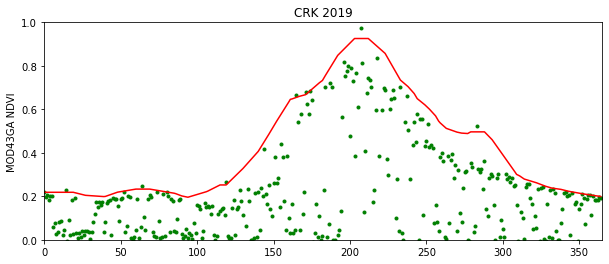

In [58]:
plt.figure(figsize=(10,4))
plt.plot(numpy.arange(end_day-start_day+1), site_show_o, '.', color='green')
plt.plot(numpy.arange(end_day-start_day+1), site_v, '-', color='red')
plt.title(site_name + ' ' + year_str)
plt.xlim(0, end_day-start_day+1)
plt.ylim(0, 1)
plt.ylabel('MOD43GA NDVI')
plt.show()

## reference

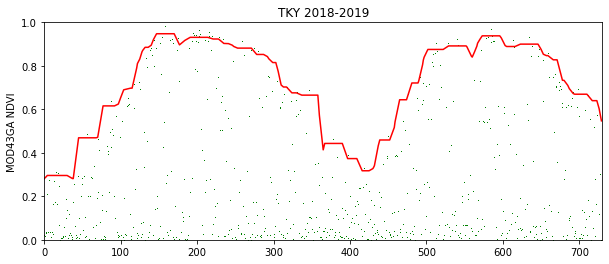

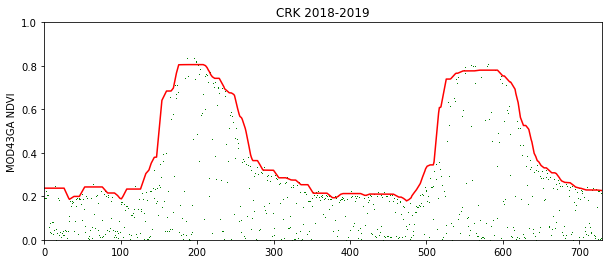

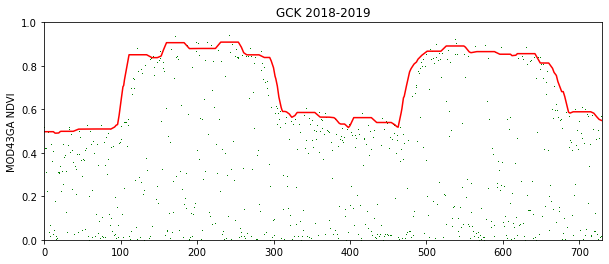

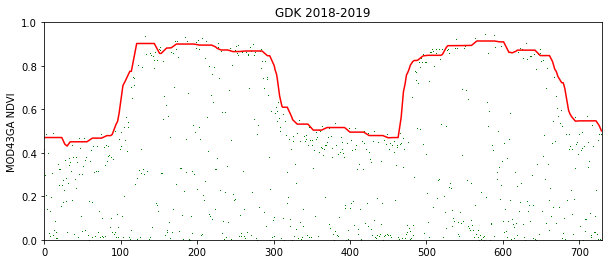

In [256]:
OUTPUT_FOLDER = '/disk2/Data/FluxSite4ET'

site_names = ['TKY','CRK', 'GCK', 'GDK']
window_sizes = [7, 7, 7, 7]

for idx in range(len(site_names)):
    site_name = site_names[idx]
    MOD43GA_REF_SITE_CSV = '/disk2/Data/FluxSite4ET/original/' + site_name + '_MOD09GA_ReflectanceB1B2.csv'
    time_list, ref1_day, ref2_day = read_site_ref(MOD43GA_REF_SITE_CSV)
    
    ndvi = (ref2_day - ref1_day) / (ref2_day + ref1_day)
    smoothed_ndvi = smooth_max_ndvi_95(ndvi, window_size=window_sizes[idx], polynomial_order=1, max_percent=0.97)
    
    ndvi_record = smoothed_ndvi.astype(str)
    ndvi_csv_ = numpy.column_stack((time_list, ndvi_record))
    numpy.savetxt(os.path.join(OUTPUT_FOLDER, site_name+'_NDVI'+'.csv'), ndvi_csv_, delimiter=",", fmt='%s')
    
    plt.figure(figsize=(10,4))
    plt.plot(numpy.arange(365*2), ndvi, '.', color='green')
    plt.plot(numpy.arange(365*2), smoothed_ndvi, '-', color='red')
    plt.title(site_name + ' 2018-2019')
    plt.xlim(0, 365*2)
    plt.ylim(0, 1)
    plt.ylabel('MOD43GA NDVI')
    plt.show()